# Importing Libraries

In [1]:
!pip install transformers
!pip install datasets
!pip install torchmetrics
!pip install optuna
!pip install -U "neptune[optuna]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel,AutoTokenizer,AdamW
from datasets import load_dataset
from tqdm.auto import tqdm
import numpy as np
import random
from torchmetrics.classification import BinaryAccuracy,MulticlassF1Score,MulticlassPrecision,MulticlassRecall,MulticlassAccuracy,BinaryConfusionMatrix
from torchmetrics.collections import MetricCollection
import optuna
from google.colab import userdata
import neptune
import uuid
import neptune.integrations.optuna as npt_utils
import  hashlib
import time
import math
import pickle
import matplotlib.pyplot as plt

# Setting up the GPU or CPU

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["NEPTUNE_API_TOKEN"] = userdata.get('NEPTUNE_API_TOKEN')
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")

# Define Variable Values

In [4]:
# @title Define Transformer Model Name
bert_model_name = "roberta-base" # @param {type:"string"}

In [5]:
# @title Define Hugging Face Dataset Name
dataset_name = "krishan-CSE/HatEval-Relabeled" # @param {type:"string"}



In [6]:
# @title Define Neptuna Project Name
project_name='krishanchavinda.official/Fine-Tuning-DCL-Framework'# @param {type:"string"}
neptune_id='FIN-3215'# @param {type:"string"} #if you want to start a new study keep it blank

In [7]:
# @title Define Experiment Name
study_name = "DCL_Experiments_2_v1" # @param {type:"string"}



In [8]:
dataset_tag = dataset_name
model_tag = bert_model_name

##Setting up Neptuna

In [9]:
def load_optuna_states(run:neptune.Run,directory:str):
  run[f'{directory}/optuna_storage'].download()
  run[f'{directory}/sampler'].download()
  run[f'{directory}/pruner'].download()
  run.wait()

In [10]:
if neptune_id=='':
  study_id=str(hashlib.md5(str(time.time()).encode()).hexdigest()[:8])
  sweep_id = uuid.uuid1()
  run_study_level = neptune.init_run(project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True,tags=[dataset_tag , "hyper-parameter-tuning", model_tag],name=(study_name+'_'+study_id))
  run_study_level["sweep-id"] = str(sweep_id)
  run_study_level["sys/tags"].add("study-level")
else:
  run_study_level = neptune.init_run(with_id=neptune_id,project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True)
  name=run_study_level["sys/name"].fetch()
  run_study_level.wait()
  study_name,study_id = tuple(name.rsplit('_', 1))
  sweep_id=run_study_level["sweep-id"].fetch()
  load_optuna_states(run=run_study_level,directory="optuna")

https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3215


In [11]:
#@title Define Transformer Model Tokenizer Max Padding Length
SEED = 1234
PADDING_MAX_LENGTH = 45  # @param {type:"integer"}


# Setting Random Seed for Reproducibility

In [12]:
def setup_seed(seed:int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [13]:
setup_seed(SEED)

# Loading Train,Dev Datasets

In [14]:
dataset = load_dataset(dataset_name)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Loading the Tokernizer for the Transformer Model

In [15]:
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

##Define the Tokenizer Function

In [16]:
def tokenize_function(examples):
    return tokenizer.batch_encode_plus(examples["text"], padding='max_length',max_length=PADDING_MAX_LENGTH,add_special_tokens=True,truncation=True)

## Tokenize the Dataset

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 2724
    })
})

In [18]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/9088 [00:00<?, ? examples/s]

Map:   0%|          | 0/1168 [00:00<?, ? examples/s]

Map:   0%|          | 0/2724 [00:00<?, ? examples/s]

In [19]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2724
    })
})

## Remove Unwanted Coloumns

In [20]:
tokenized_datasets=tokenized_datasets.remove_columns(['text'])

In [21]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 9088
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1168
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2724
    })
})

## Format the coloumns

In [22]:
tokenized_datasets=tokenized_datasets.with_format("torch")

# Define the Dual Contrastive Learning Architecture



In [23]:
class DCLArchitecture(nn.Module):
    def __init__(self,dropout:float,bert_model_name:str='bert-base-cased'):
        super(DCLArchitecture, self).__init__()
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dim = 768
        self.dense = nn.Linear(self.dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,batch_tokenized, if_train=False):
        input_ids = batch_tokenized['input_ids']
        attention_mask = batch_tokenized['attention_mask']
        bert_output = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        bert_cls_hidden_state = bert_output[1]

        if if_train:
            bert_cls_hidden_state_aug = self.dropout(bert_cls_hidden_state)
            bert_cls_hidden_state = torch.cat((bert_cls_hidden_state, bert_cls_hidden_state_aug), dim=1).reshape(-1, self.dim)
        else:
            bert_cls_hidden_state = self.dropout(bert_cls_hidden_state)

        linear_output = self.dense(bert_cls_hidden_state)
        linear_output = linear_output.squeeze(1)

        return bert_cls_hidden_state, linear_output

## Define Focal Loss

In [24]:
class FocalLoss(nn.Module):
    def __init__(self, alpha:float=0.4, gamma:float=2, size_average:bool=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.size_average = size_average

    def forward(self, pred, target):

        device = target.device
        self.alpha = self.alpha.to(device)

        pred = nn.Sigmoid()(pred)
        pred = pred.view(-1, 1)
        target = target.view(-1, 1)
        pred = torch.cat((1-pred, pred), dim=1)

        class_mask = torch.zeros(pred.shape[0], pred.shape[1]).to(device)
        class_mask.scatter_(1, target.view(-1, 1).long(), 1.)
        probs = (pred * class_mask).sum(dim=1).view(-1, 1)
        probs = probs.clamp(min=0.0001, max=1.0)

        log_p = probs.log()
        alpha = torch.ones(pred.shape[0], pred.shape[1]).to(device)
        alpha[:, 0] = alpha[:, 0] * (1 - self.alpha)
        alpha[:, 1] = alpha[:, 1] * self.alpha
        alpha = (alpha * class_mask).sum(dim=1).view(-1, 1)

        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p

        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()

        return loss

## Define Unsupervised Contrastive loss

In [25]:
def simcse_loss(batch_emb,temp_1:float):
    batch_size = batch_emb.size(0)
    y_true = torch.cat([torch.arange(1, batch_size, step=2, dtype=torch.long).unsqueeze(1),
                        torch.arange(0, batch_size, step=2, dtype=torch.long).unsqueeze(1)],
                       dim=1).reshape([batch_size,]).to(device)
    norm_emb = F.normalize(batch_emb, dim=1, p=2)
    sim_score = torch.matmul(norm_emb, norm_emb.transpose(0,1))
    sim_score = sim_score - (torch.eye(batch_size) * 1e12).to(device)
    sim_score = sim_score / temp_1
    loss_func = nn.CrossEntropyLoss()
    loss = loss_func(sim_score, y_true)

    return loss


## Define Supervised Contrastive loss

In [26]:
def sup_simcse_loss(batch_emb, label,temp_2:float):
    n = batch_emb.size(0)

    similarity_matrix = F.cosine_similarity(batch_emb.unsqueeze(1), batch_emb.unsqueeze(0), dim=2)
    mask = torch.ones_like(similarity_matrix) * (label.expand(n, n).eq(label.expand(n, n).t()))

    mask_no_sim = torch.ones_like(mask) - mask
    mask_dui_jiao_0 = ((torch.ones(n,n) - torch.eye(n,n)) * 1e12).to(device)
    similarity_matrix = torch.exp(similarity_matrix/temp_2)
    similarity_matrix = similarity_matrix * mask_dui_jiao_0

    sim = mask*similarity_matrix
    no_sim = similarity_matrix - sim
    no_sim_sum = torch.sum(no_sim , dim=1)
    no_sim_sum_expend = no_sim_sum.repeat(n, 1).T

    sim_sum  = sim + no_sim_sum_expend
    loss = torch.div(sim , sim_sum)
    loss = mask_no_sim + loss + (torch.eye(n, n)/1e12).to(device)
    loss = -torch.log(loss)
    loss = torch.sum(torch.sum(loss, dim=1))/(2*n)
    return loss

# Fine Tuning the Model

In [27]:
optuna_storage_location="content/optuna_storage.db"

## Format the Labels

In [28]:
def copy_label(labels):
    labels = labels.unsqueeze(1)
    labels = torch.cat((labels, labels), dim=1).reshape(-1, 1).squeeze(1)
    return labels

In [29]:
def is_supported_values(value):
  if not math.isinf(value) and not math.isnan(value):
    return True
  else:
    return False

## Define Training Loop

In [30]:
def training_loop(model, train_dataloader,optimizer,criteon,device,temp_1:float,temp_2:float,lamda:float,run_trial_level):
    accuracy_metric = BinaryAccuracy()
    accuracy_metric.to(device)
    progress_bar = tqdm(range(len(train_dataloader)))
    model.train()
    total_train_loss = 0.0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = copy_label(batch["labels"])
        emb, pred = model(batch, if_train=True)
        loss = criteon(pred, labels.float())
        loss_sim = simcse_loss(emb,temp_1=temp_1)
        loss_supsim = sup_simcse_loss(emb, labels,temp_2=temp_2)
        total_train_loss += loss.item()

        loss_value=loss.item()
        if is_supported_values(loss_value):
          run_trial_level["train/batch/loss"].append(loss_value)
        if is_supported_values(loss_sim):
          run_trial_level["train/batch/Unsupervised_Contrastive_loss"].append(loss_sim)
        if is_supported_values(loss_supsim):
          run_trial_level["train/batch/supervised_Contrastive_loss"].append(loss_supsim)

        pred_sig = torch.sigmoid(pred)

        preds_detach=torch.round(pred_sig.detach())

        batch_level_accuracy=accuracy_metric(preds_detach,labels)

        if is_supported_values(batch_level_accuracy.item()):
          run_trial_level["train/batch/accuracy"].append(batch_level_accuracy.item())
        loss = loss + lamda*(loss_sim + loss_supsim)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    average_epoch_train_loss = total_train_loss / len(train_dataloader)  # Compute average epoch loss
    train_accuracy =  accuracy_metric.compute()
    accuracy_metric.reset()
    return average_epoch_train_loss,train_accuracy


## Define Validation Loop

In [31]:
def validation_loop(model, dev_dataloader,criteon, device,average='macro'):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_dev_loss = 0.0
    for batch in dev_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]

        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred_sig = torch.round(torch.sigmoid(pred))
        nan_exist = torch.isnan(pred_sig).any().item()
        if nan_exist:
          collection_metric.reset()
          return None
        total_dev_loss += loss.item()
        collection_metric.update(pred_sig,labels)
    average_epoch_dev_loss = total_dev_loss / len(dev_dataloader)  # Compute average epoch loss
    result = collection_metric.compute()
    result["Loss"]=average_epoch_dev_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

## Define Test Loop

In [32]:
def test_loop(model, test_dataloader,criteon, device,average:str="macro"):
    collection_metric = MetricCollection(
          BinaryAccuracy(),
          MulticlassPrecision(num_classes=2,average=average),
          MulticlassRecall(num_classes=2,average=average),
          MulticlassF1Score(num_classes=2,average=average),
          BinaryConfusionMatrix()
    )
    collection_metric.to(device)
    model.eval()
    total_test_loss = 0.0
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch["labels"]
        with torch.no_grad():
            emb, pred = model(batch , False)
            loss = criteon(pred, labels.float())
            pred = torch.round(torch.sigmoid(pred))
        total_test_loss += loss.item()
        collection_metric.update(pred, labels)
    average_epoch_test_loss = total_test_loss / len(test_dataloader)  # Compute average epoch loss
    result =  collection_metric.compute()
    result['Loss']= average_epoch_test_loss
    result["BinaryConfusionMatrix"],_=collection_metric.BinaryConfusionMatrix.plot()
    collection_metric.reset()
    return result

## Hyperparameter Tuning

In [33]:
storage = optuna.storages.RDBStorage("sqlite:////"+optuna_storage_location)

In [34]:
def define_model(bert_model_name:str):
    DROPOUT = 0.5
    model = DCLArchitecture(bert_model_name=bert_model_name,dropout=DROPOUT)
    model.to(device)
    return model

In [35]:
def get_data_loaders(trial,tokenized_datasets):
    BATCH_SIZE = trial.suggest_int("batch_size",100,256)
    train_dataloader=DataLoader(tokenized_datasets["train"], batch_size=BATCH_SIZE , shuffle=False)
    dev_dataloader=DataLoader(tokenized_datasets["validation"], batch_size=BATCH_SIZE , shuffle=False)
    test_dataloader=DataLoader(tokenized_datasets["test"], batch_size=BATCH_SIZE , shuffle=False)
    return train_dataloader,dev_dataloader,test_dataloader,BATCH_SIZE


In [36]:
def save_optuna_states():
  with open("sampler.pkl", "wb") as fout:
    pickle.dump(study.sampler, fout)
  with open("pruner.pkl", "wb") as fout:
    pickle.dump(study.pruner, fout)

In [37]:
def upload_optuna_states(run:neptune.Run,directory:str):
    run[f"{directory}/sampler"].upload('sampler.pkl')
    run[f"{directory}/pruner"].upload('pruner.pkl')
    run[f"{directory}/optuna_storage"].upload("optuna_storage.db")
    run.wait()


In [38]:
def upload_metrics_result(directory:str,result:dict,run: neptune.Run):
    run[f"{directory}/Accuracy"]=result["BinaryAccuracy"].item()
    run[f"{directory}/Focal_Loss"]=result["Loss"]
    run[f"{directory}/Macro_Precision"]=result["MulticlassPrecision"].item()
    run[f"{directory}/Macro_Recall"]=result["MulticlassRecall"].item()
    run[f"{directory}/Macro_F1Score"]=result["MulticlassF1Score"].item()
    run[f"{directory}/ConfusionMatrix"].upload(result["BinaryConfusionMatrix"])
    run.wait()
    plt.close()

In [39]:
def upload_metrics_series_result(directory:str,result:dict,run: neptune.Run):
    run[f"{directory}/Accuracy"].append(result["BinaryAccuracy"].item())
    run[f"{directory}/Focal_Loss"].append(result["Loss"])
    run[f"{directory}/Macro_Precision"].append(result["MulticlassPrecision"].item())
    run[f"{directory}/Macro_Recall"].append(result["MulticlassRecall"].item())
    run[f"{directory}/Macro_F1Score"].append(result["MulticlassF1Score"].item())
    run.wait()

In [40]:
def objective(trial):
    # Define the hyperparameters to optimize
    setup_seed(SEED)
    EPOCHS = trial.suggest_int("epochs",1,2)
    ALPHA= 0.3 #trial.suggest_float("alpha", 0.20,0.4,log=True)
    GAMMA = 2 #trial.suggest_float("gamma", 0.1,5.0)
    TEMP_1 = trial.suggest_float("temp_1", 0.001,0.8,log=True)
    TEMP_2 = trial.suggest_float("temp_2", 0.001,0.8,log=True)
    LAMBDA = trial.suggest_float("lambda", 0.6,1.0)
    LR = trial.suggest_float("learning_rate", 1e-5 ,1e-3,log=True)
    train_dataloader,dev_dataloader,test_dataloader,BATCH_SIZE = get_data_loaders(trial=trial,tokenized_datasets=tokenized_datasets)
    model = define_model(bert_model_name=bert_model_name)
    optimizer = torch.optim.AdamW(model.parameters(),lr = LR)
    criteon = FocalLoss(ALPHA, GAMMA)
    param = {
        "EPOCHS": EPOCHS,
        "ALPHA": ALPHA,
        "GAMMA": GAMMA,
        "TEMP_1": TEMP_1,
        "TEMP_2":TEMP_2,
        "BATCH_SIZE":BATCH_SIZE,
        "LEARNING_RATE":LR,
        "DROPOUT":0.5,
        "LAMBDA":LAMBDA,
        "SEED":SEED
    }

     # Create a trial-level run
    run_trial_level = neptune.init_run(project=project_name,capture_stdout=True,capture_stderr=True,capture_traceback=True, capture_hardware_metrics=True,
    name=study_name+"_"+str(study_id)+"_"+str(trial.number),tags=[model_tag,dataset_tag,(study_name+'_'+study_id),str(trial.number+1)])

    # Log sweep ID to trial-level run
    run_trial_level["sys/tags"].add("trial-level")
    run_trial_level["sweep-id"] = str(sweep_id)

    # Log parameters of a trial-level run
    run_trial_level["parameters"] = param

    for epoch in range(EPOCHS):
        average_epoch_train_loss,train_accuracy = training_loop(model=model, train_dataloader=train_dataloader,optimizer=optimizer,criteon=criteon,device=device,temp_1=TEMP_1,temp_2=TEMP_2,lamda=LAMBDA,run_trial_level=run_trial_level)
        dev_result_metrics = validation_loop(model=model,dev_dataloader=dev_dataloader,criteon=criteon,device=device)

        if  dev_result_metrics==None:
              objective_value=-1
        else:
              objective_value = dev_result_metrics['MulticlassF1Score'].item()
        trial.report(objective_value, epoch)
        if trial.should_prune():
            run_trial_level["sys/tags"].add("pruned")
            run_trial_level.stop()
            raise optuna.exceptions.TrialPruned()


        run_trial_level["train/epoch/Focal_Loss"].append(average_epoch_train_loss)
        run_trial_level["train/epoch/accuracy"].append(train_accuracy.item())

        upload_metrics_series_result(directory="evaluation/epoch",result=dev_result_metrics,run=run_trial_level)

    run_trial_level["train/Focal_Loss"]=average_epoch_train_loss
    run_trial_level["train/accuracy"]=train_accuracy.item()

    upload_metrics_result(directory="evaluation",result=dev_result_metrics,run=run_trial_level)

    if dev_result_metrics!=None:
        result_metrics=test_loop(model=model, test_dataloader=test_dataloader,criteon=criteon,device=device)
        upload_metrics_result(run=run_trial_level,directory="Test_Results",result=result_metrics)

    # Stop trial-level Run
    run_trial_level.stop()
    save_optuna_states()
    upload_optuna_states(run=run_study_level,directory="optuna")
    return objective_value


In [41]:
if neptune_id=='':
    sampler = optuna.samplers.TPESampler(seed=SEED,multivariate=True,group=True,n_startup_trials=20,consider_prior=True)
    pruner=optuna.pruners.ThresholdPruner(lower=0)
else:
    sampler=pickle.load(open("sampler.pkl", "rb"))
    pruner=pickle.load(open("pruner.pkl", "rb"))

In [42]:
neptune_callback = npt_utils.NeptuneCallback(run_study_level)

In [43]:
study = optuna.create_study(study_name=study_name,storage=storage,load_if_exists=True,direction='maximize',sampler=sampler,pruner=pruner)

[I 2024-01-01 15:27:23,719] Using an existing study with name 'DCL_Experiments_2_v1' instead of creating a new one.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3301


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3301/metadata


[I 2024-01-01 15:29:48,521] Trial 84 finished with value: 0.7614140510559082 and parameters: {'epochs': 2, 'temp_1': 0.4623088859388554, 'temp_2': 0.1547859952922781, 'lambda': 0.843063976280192, 'learning_rate': 2.9468803830797517e-05, 'batch_size': 177}. Best is trial 31 with value: 0.7680023312568665.
[W 2024-01-01 15:29:49,596] Param temp_1 unique value length is less than 2.
[W 2024-01-01 15:29:49,598] Param temp_2 unique value length is less than 2.
[W 2024-01-01 15:29:49,606] Param temp_1 unique value length is less than 2.
[W 2024-01-01 15:29:49,607] Param temp_2 unique value length is less than 2.
[W 2024-01-01 15:29:49,613] Param temp_1 unique value length is less than 2.
[W 2024-01-01 15:29:49,615] Param temp_2 unique value length is less than 2.
[W 2024-01-01 15:29:49,621] Param temp_1 unique value length is less than 2.
[W 2024-01-01 15:29:49,622] Param temp_2 unique value length is less than 2.
[W 2024-01-01 15:29:49,626] Param temp_1 unique value length is less than 2.
[

https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3302


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3302/metadata


[I 2024-01-01 15:32:13,096] Trial 85 finished with value: 0.7763034105300903 and parameters: {'epochs': 2, 'temp_1': 0.7910656153811724, 'temp_2': 0.1927953791900298, 'lambda': 0.7976834613964731, 'learning_rate': 3.622607672945143e-05, 'batch_size': 180}. Best is trial 85 with value: 0.7763034105300903.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3303


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3303/metadata


[I 2024-01-01 15:34:36,235] Trial 86 finished with value: 0.7528979182243347 and parameters: {'epochs': 2, 'temp_1': 0.5772518142042495, 'temp_2': 0.16750719556471527, 'lambda': 0.7361986929483273, 'learning_rate': 2.751151655188845e-05, 'batch_size': 190}. Best is trial 85 with value: 0.7763034105300903.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3304


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3304/metadata


[I 2024-01-01 15:36:54,650] Trial 87 finished with value: 0.7883968949317932 and parameters: {'epochs': 2, 'temp_1': 0.7404708738385563, 'temp_2': 0.21250068194400165, 'lambda': 0.7213752164597451, 'learning_rate': 1.5292164808429662e-05, 'batch_size': 166}. Best is trial 87 with value: 0.7883968949317932.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3305


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3305/metadata


[I 2024-01-01 15:39:13,707] Trial 88 finished with value: 0.7795453071594238 and parameters: {'epochs': 2, 'temp_1': 0.629955258216648, 'temp_2': 0.1827892338235747, 'lambda': 0.6622450164259277, 'learning_rate': 1.9833244794844563e-05, 'batch_size': 168}. Best is trial 87 with value: 0.7883968949317932.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3306


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3306/metadata


[I 2024-01-01 15:41:32,679] Trial 89 finished with value: 0.7917819619178772 and parameters: {'epochs': 2, 'temp_1': 0.7179592555508209, 'temp_2': 0.25048602938217246, 'lambda': 0.7427180391756568, 'learning_rate': 1.317151497593518e-05, 'batch_size': 166}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3307


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3307/metadata


[I 2024-01-01 15:43:55,097] Trial 90 finished with value: 0.7191762924194336 and parameters: {'epochs': 2, 'temp_1': 0.627498945471075, 'temp_2': 0.1780957978159706, 'lambda': 0.6810071514796767, 'learning_rate': 1.061293799229314e-05, 'batch_size': 175}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3308


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3308/metadata


[I 2024-01-01 15:46:20,886] Trial 91 finished with value: 0.7862870693206787 and parameters: {'epochs': 2, 'temp_1': 0.4948119362761196, 'temp_2': 0.26888424322907273, 'lambda': 0.7730749085727433, 'learning_rate': 1.2679687927127234e-05, 'batch_size': 155}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3309


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3309/metadata


[I 2024-01-01 15:48:39,254] Trial 92 finished with value: 0.7768410444259644 and parameters: {'epochs': 2, 'temp_1': 0.7023432183030744, 'temp_2': 0.2774192950465918, 'lambda': 0.7804738350338303, 'learning_rate': 1.5281726885597955e-05, 'batch_size': 170}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3310


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3310/metadata


[I 2024-01-01 15:51:03,996] Trial 93 finished with value: 0.7724151611328125 and parameters: {'epochs': 2, 'temp_1': 0.6936491111267677, 'temp_2': 0.2144974992150386, 'lambda': 0.8019446123255332, 'learning_rate': 1.7172521436268676e-05, 'batch_size': 171}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3311


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3311/metadata


[I 2024-01-01 15:53:23,175] Trial 94 finished with value: 0.7849242687225342 and parameters: {'epochs': 2, 'temp_1': 0.7232352968826119, 'temp_2': 0.22680867580250957, 'lambda': 0.8004706315070675, 'learning_rate': 1.6317740425357883e-05, 'batch_size': 166}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3312


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3312/metadata


[I 2024-01-01 15:55:46,309] Trial 95 finished with value: 0.7916964292526245 and parameters: {'epochs': 2, 'temp_1': 0.7733766073386898, 'temp_2': 0.2572155101558198, 'lambda': 0.7238957891247075, 'learning_rate': 2.3830303475673126e-05, 'batch_size': 161}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3313


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3313/metadata


[I 2024-01-01 15:58:05,661] Trial 96 finished with value: 0.7800981998443604 and parameters: {'epochs': 2, 'temp_1': 0.5401063809356041, 'temp_2': 0.2863515262864252, 'lambda': 0.7744865786472578, 'learning_rate': 1.3350137303948655e-05, 'batch_size': 165}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3314


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3314/metadata


[I 2024-01-01 16:00:27,884] Trial 97 finished with value: 0.7849500179290771 and parameters: {'epochs': 2, 'temp_1': 0.6918379650503278, 'temp_2': 0.3050274019015468, 'lambda': 0.7816634278422318, 'learning_rate': 1.2129280644890707e-05, 'batch_size': 162}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3315


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3315/metadata


[I 2024-01-01 16:02:46,909] Trial 98 finished with value: 0.7838504314422607 and parameters: {'epochs': 2, 'temp_1': 0.6303453509177697, 'temp_2': 0.3566824964282427, 'lambda': 0.7863956545199061, 'learning_rate': 1.3548792193258237e-05, 'batch_size': 150}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3316


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3316/metadata


[I 2024-01-01 16:05:07,418] Trial 99 finished with value: 0.7846251726150513 and parameters: {'epochs': 2, 'temp_1': 0.6195819152653069, 'temp_2': 0.6740682972866806, 'lambda': 0.7857242574105763, 'learning_rate': 1.1241102658549846e-05, 'batch_size': 147}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3317


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3317/metadata


[I 2024-01-01 16:07:32,981] Trial 100 finished with value: 0.733394205570221 and parameters: {'epochs': 2, 'temp_1': 0.7801757472056003, 'temp_2': 0.6009001945908632, 'lambda': 0.773781767583956, 'learning_rate': 2.097644659267849e-05, 'batch_size': 146}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3318


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3318/metadata


[I 2024-01-01 16:09:58,800] Trial 101 finished with value: 0.7910952568054199 and parameters: {'epochs': 2, 'temp_1': 0.2295808649887364, 'temp_2': 0.6584177455893029, 'lambda': 0.6958625426275179, 'learning_rate': 2.2110024985514712e-05, 'batch_size': 156}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3319


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3319/metadata


[I 2024-01-01 16:12:17,864] Trial 102 finished with value: 0.7902569770812988 and parameters: {'epochs': 2, 'temp_1': 0.0794314922054644, 'temp_2': 0.47523025202240105, 'lambda': 0.6986013985427583, 'learning_rate': 2.340631042367674e-05, 'batch_size': 150}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3320


  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3320/metadata


[I 2024-01-01 16:14:39,177] Trial 103 finished with value: 0.7854893207550049 and parameters: {'epochs': 2, 'temp_1': 0.058319144214103696, 'temp_2': 0.6792032529211389, 'lambda': 0.7062129728107833, 'learning_rate': 2.1117275513234193e-05, 'batch_size': 148}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3321


  0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3321/metadata


[I 2024-01-01 16:15:58,015] Trial 104 finished with value: 0.6804611682891846 and parameters: {'epochs': 1, 'temp_1': 0.04344475664331279, 'temp_2': 0.7103703922415637, 'lambda': 0.7073510072353009, 'learning_rate': 1.10733039999068e-05, 'batch_size': 157}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3322


  0%|          | 0/61 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/plot.py:245: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



  0%|          | 0/61 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3322/metadata


[I 2024-01-01 16:18:22,917] Trial 105 finished with value: 0.780460000038147 and parameters: {'epochs': 2, 'temp_1': 0.08410853081377066, 'temp_2': 0.42251303314944416, 'lambda': 0.7059371011219715, 'learning_rate': 1.1831712161340393e-05, 'batch_size': 151}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3323


  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3323/metadata


[I 2024-01-01 16:20:49,946] Trial 106 finished with value: 0.7818376421928406 and parameters: {'epochs': 2, 'temp_1': 0.2722474277427489, 'temp_2': 0.7589456753081716, 'lambda': 0.762514761984473, 'learning_rate': 1.4499347936363448e-05, 'batch_size': 132}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3324


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3324/metadata


[I 2024-01-01 16:23:16,456] Trial 107 finished with value: 0.7809573411941528 and parameters: {'epochs': 2, 'temp_1': 0.15368508109515575, 'temp_2': 0.6728620382101076, 'lambda': 0.7353054880250984, 'learning_rate': 1.471814631034338e-05, 'batch_size': 156}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3325


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3325/metadata


[I 2024-01-01 16:25:42,259] Trial 108 finished with value: 0.7756648063659668 and parameters: {'epochs': 2, 'temp_1': 0.7509095060644332, 'temp_2': 0.7441250046439164, 'lambda': 0.7000788202467949, 'learning_rate': 4.773061107854376e-05, 'batch_size': 173}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3326


  0%|          | 0/68 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3326/metadata


[I 2024-01-01 16:26:40,129] Trial 109 pruned. 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3327


  0%|          | 0/64 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3327/metadata


[I 2024-01-01 16:27:36,781] Trial 110 pruned. 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3328


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3328/metadata


[I 2024-01-01 16:29:56,299] Trial 111 finished with value: 0.59201979637146 and parameters: {'epochs': 2, 'temp_1': 0.01786050761733221, 'temp_2': 0.12328078134337764, 'lambda': 0.8941140815305731, 'learning_rate': 1.0625633303053422e-05, 'batch_size': 167}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3329


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3329/metadata


[I 2024-01-01 16:32:20,097] Trial 112 finished with value: 0.7693129777908325 and parameters: {'epochs': 2, 'temp_1': 0.1791830667781397, 'temp_2': 0.773569937776302, 'lambda': 0.8110151765843107, 'learning_rate': 1.0429853509615783e-05, 'batch_size': 127}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3330


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3330/metadata


[I 2024-01-01 16:34:44,800] Trial 113 finished with value: 0.7823859453201294 and parameters: {'epochs': 2, 'temp_1': 0.310646491459526, 'temp_2': 0.4461892930268068, 'lambda': 0.7550714610326337, 'learning_rate': 1.2675814409377298e-05, 'batch_size': 127}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3331


  0%|          | 0/60 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3331/metadata


[I 2024-01-01 16:35:54,171] Trial 114 pruned. 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3332


  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3332/metadata


[I 2024-01-01 16:38:19,687] Trial 115 finished with value: 0.7737576961517334 and parameters: {'epochs': 2, 'temp_1': 0.7335922906634119, 'temp_2': 0.2820254964634313, 'lambda': 0.7661225464907018, 'learning_rate': 1.0068965067202682e-05, 'batch_size': 136}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3333


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3333/metadata


[I 2024-01-01 16:40:45,821] Trial 116 finished with value: 0.7691419720649719 and parameters: {'epochs': 2, 'temp_1': 0.001700408726276165, 'temp_2': 0.3295988669525536, 'lambda': 0.7733736729303874, 'learning_rate': 1.096613720216132e-05, 'batch_size': 153}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3334


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3334/metadata


[I 2024-01-01 16:43:07,392] Trial 117 finished with value: 0.6603658199310303 and parameters: {'epochs': 2, 'temp_1': 0.09026631944066228, 'temp_2': 0.18136016657027823, 'lambda': 0.7398496188482477, 'learning_rate': 1.0032212560761815e-05, 'batch_size': 179}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3335


  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3335/metadata


[I 2024-01-01 16:45:29,909] Trial 118 finished with value: 0.7867798805236816 and parameters: {'epochs': 2, 'temp_1': 0.7896014267933807, 'temp_2': 0.36102942618508194, 'lambda': 0.7195445150808701, 'learning_rate': 4.118917657179837e-05, 'batch_size': 161}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3336


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
All 4 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3336/metadata


[I 2024-01-01 16:47:55,522] Trial 119 finished with value: 0.7814587950706482 and parameters: {'epochs': 2, 'temp_1': 0.7952118654104487, 'temp_2': 0.6846328244146512, 'lambda': 0.7312089989264078, 'learning_rate': 3.4643172133660306e-05, 'batch_size': 155}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3337


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3337/metadata


[I 2024-01-01 16:50:21,830] Trial 120 finished with value: 0.7835189700126648 and parameters: {'epochs': 2, 'temp_1': 0.7186317583429481, 'temp_2': 0.22303988289145418, 'lambda': 0.6649849996937165, 'learning_rate': 3.641716058249518e-05, 'batch_size': 172}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3338


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3338/metadata


[I 2024-01-01 16:52:43,910] Trial 121 finished with value: 0.7683382034301758 and parameters: {'epochs': 2, 'temp_1': 0.794591496006707, 'temp_2': 0.29624038913312095, 'lambda': 0.7750767342465573, 'learning_rate': 3.5354450408284184e-05, 'batch_size': 159}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3339


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3339/metadata


[I 2024-01-01 16:55:03,922] Trial 122 finished with value: 0.7769850492477417 and parameters: {'epochs': 2, 'temp_1': 0.6668670273980621, 'temp_2': 0.24927548969683921, 'lambda': 0.6506114676388489, 'learning_rate': 3.4965168738189635e-05, 'batch_size': 165}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3340


  0%|          | 0/58 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3340/metadata


[I 2024-01-01 16:56:00,905] Trial 123 pruned. 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3341


  0%|          | 0/54 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 2 operations to synchronize with Neptune. Do not kill this process.
All 2 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3341/metadata


[I 2024-01-01 16:56:58,426] Trial 124 pruned. 
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3342


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3342/metadata


[I 2024-01-01 16:59:19,630] Trial 125 finished with value: 0.5344047546386719 and parameters: {'epochs': 2, 'temp_1': 0.2443290323370636, 'temp_2': 0.039702960377188894, 'lambda': 0.7794314686937925, 'learning_rate': 1.1242747175907928e-05, 'batch_size': 198}. Best is trial 89 with value: 0.7917819619178772.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3343


  0%|          | 0/55 [00:00<?, ?it/s]

[W 2024-01-01 16:59:45,262] Trial 126 failed with parameters: {'epochs': 2, 'temp_1': 0.6564295324434076, 'temp_2': 0.10018713690336917, 'lambda': 0.832929082315752, 'learning_rate': 1.432108159782318e-05, 'batch_size': 167} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-40-48f03f9ad48e>", line 40, in objective
    average_epoch_train_loss,train_accuracy = training_loop(model=model, train_dataloader=train_dataloader,optimizer=optimizer,criteon=criteon,device=device,temp_1=TEMP_1,temp_2=TEMP_2,lamda=LAMBDA,run_trial_level=run_trial_level)
  File "<ipython-input-30-02aa740ffcdc>", line 8, in training_loop
    batch = {k: v.to(device) for k, v in batch.items()}
  File "<ipython-input-30-02aa740ffcdc>", line 8, in <dictcomp>
    batch = {k: v.to(device) for k, v in batch.items()}
KeyboardInterru

KeyboardInterrupt: ignored

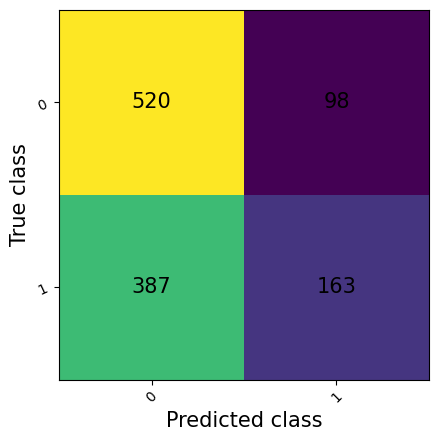

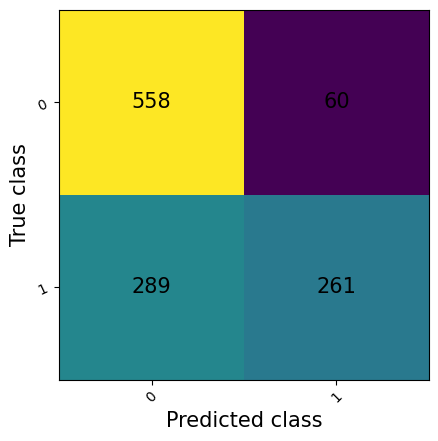

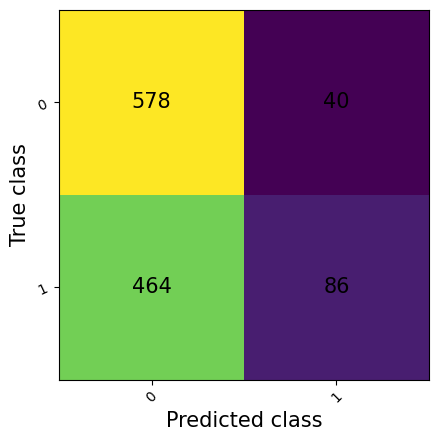

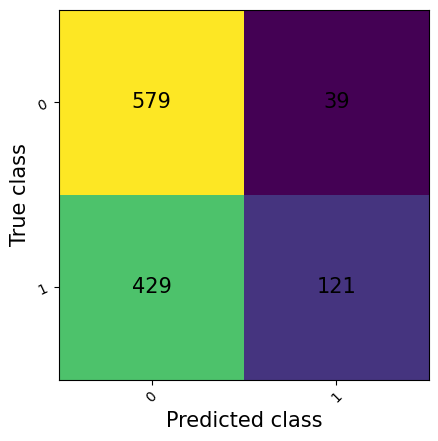

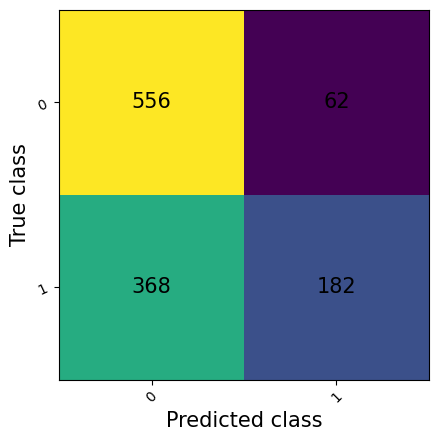

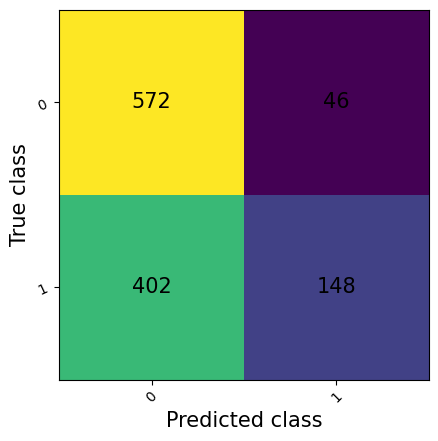

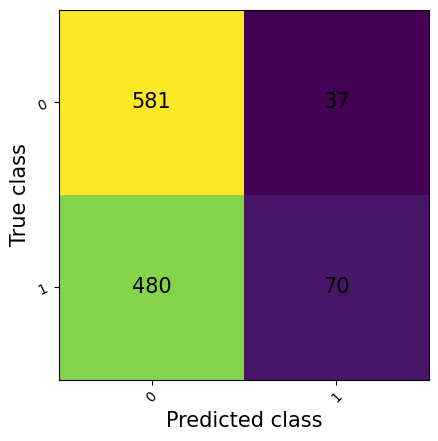

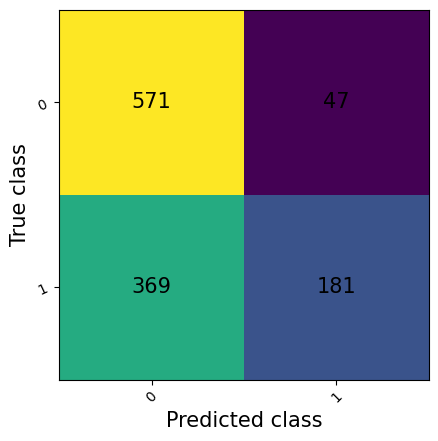

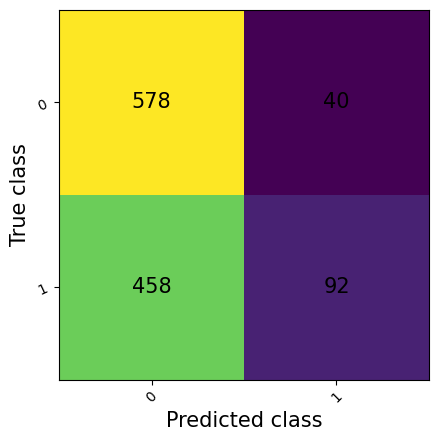

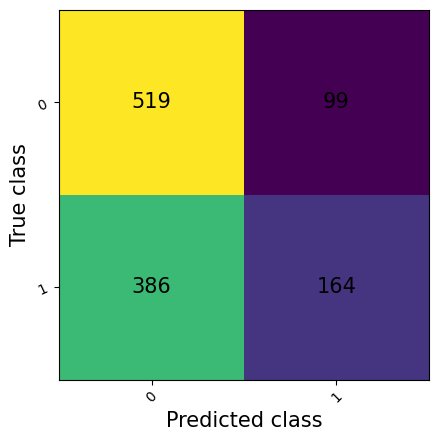

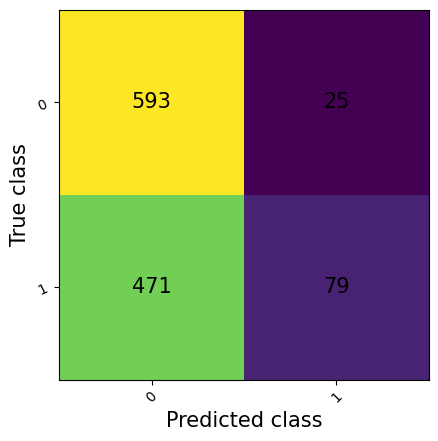

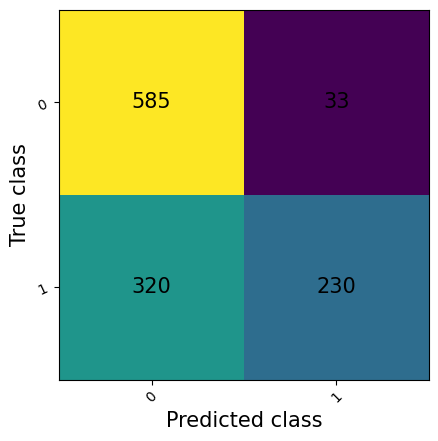

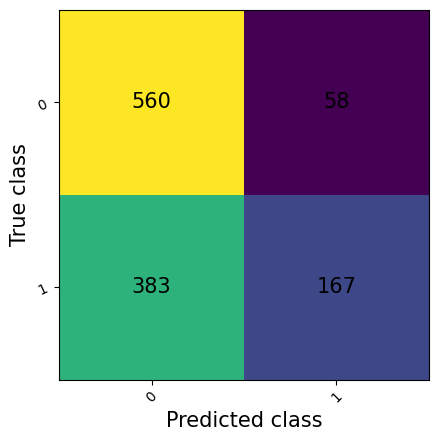

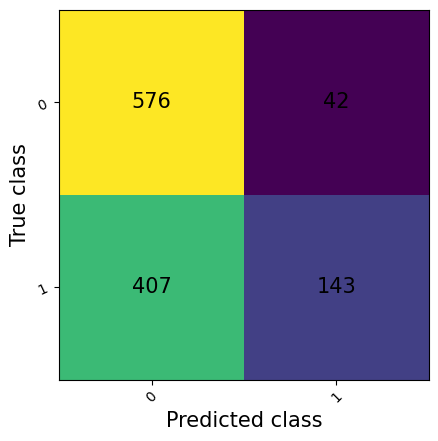

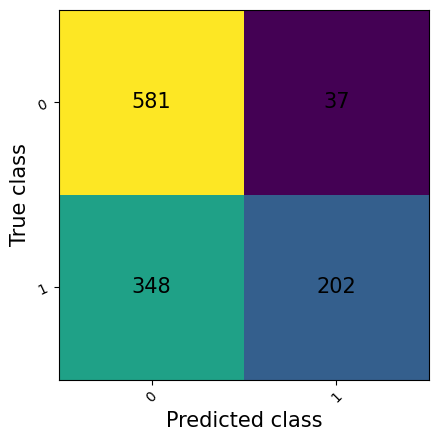

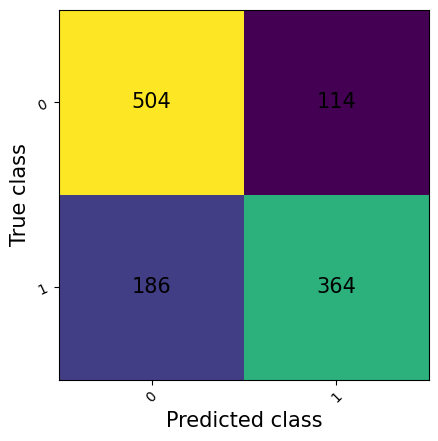

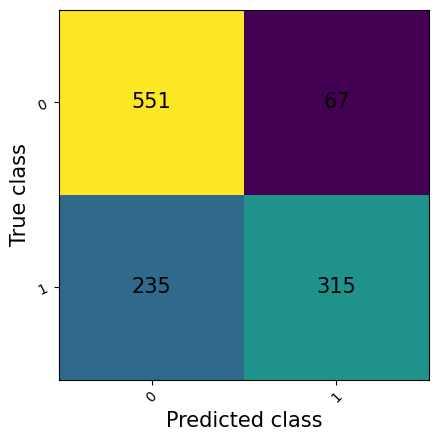

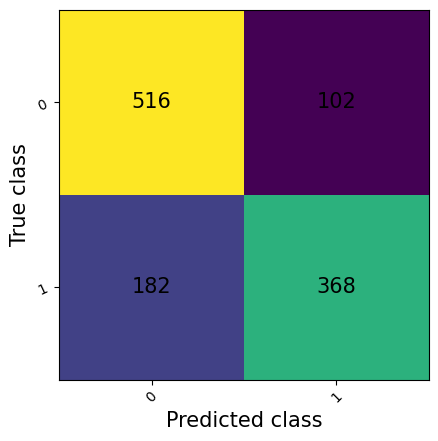

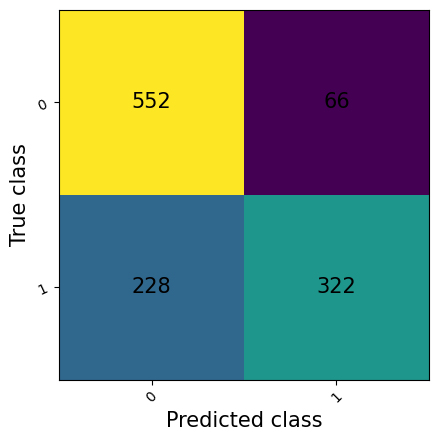

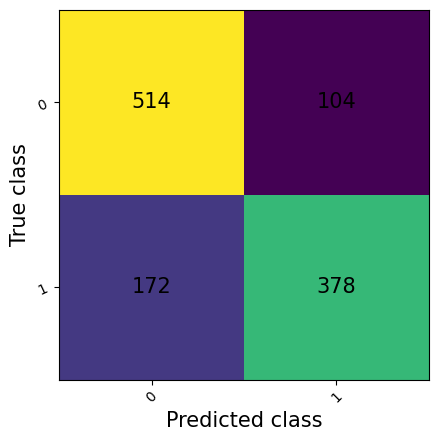

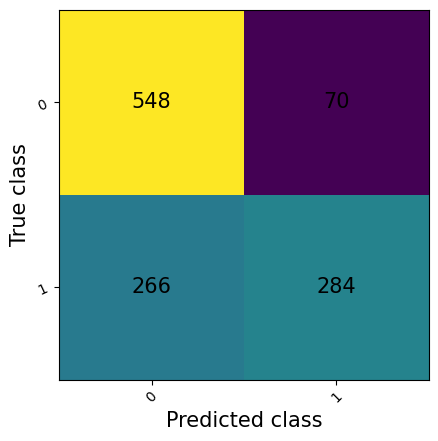

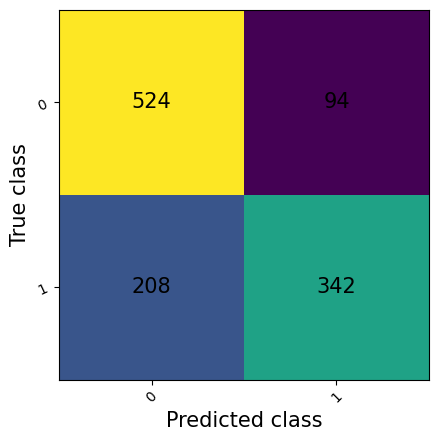

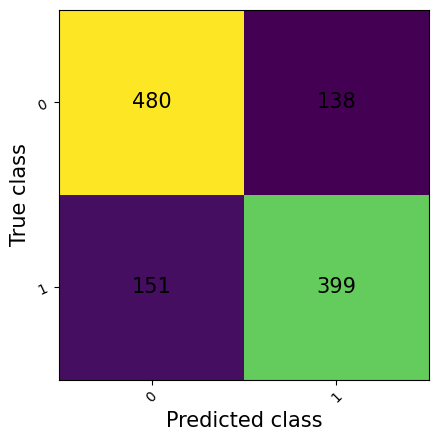

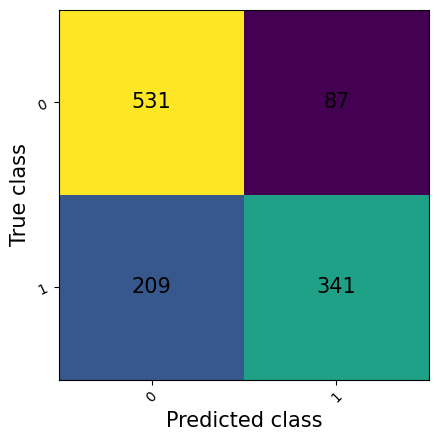

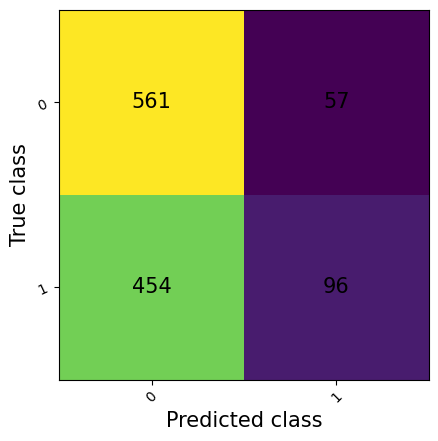

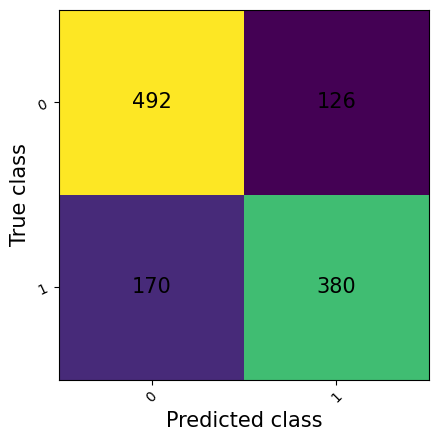

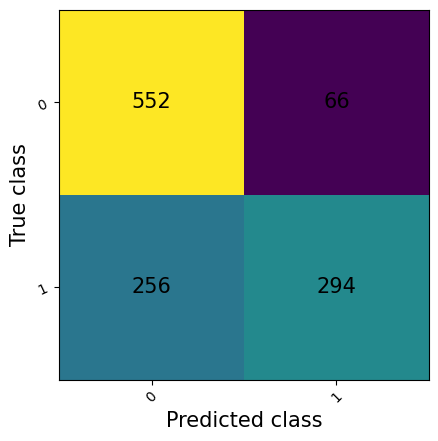

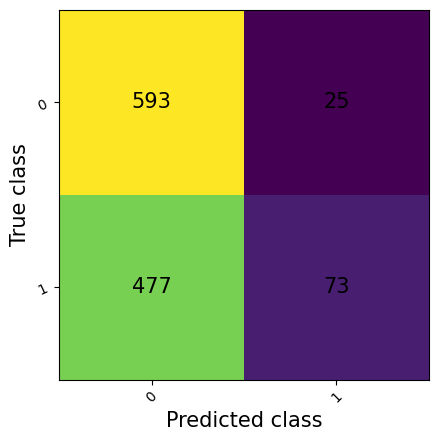

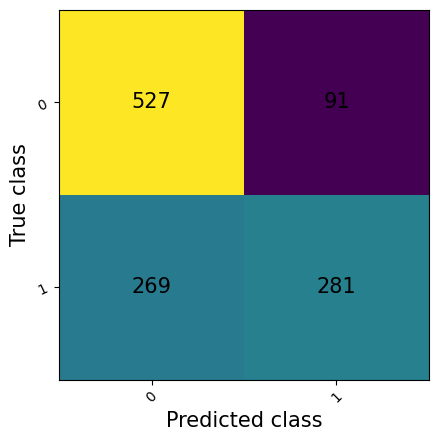

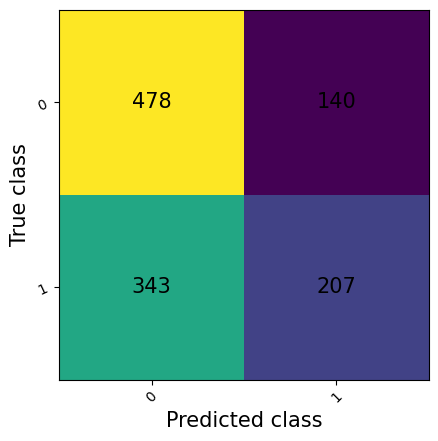

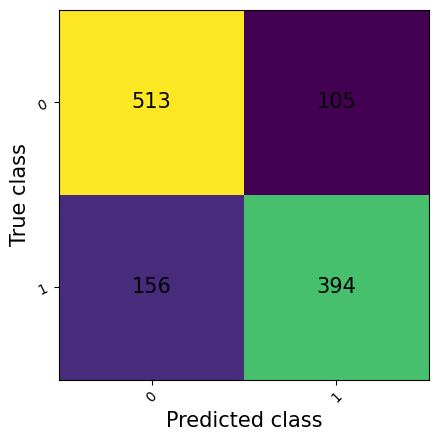

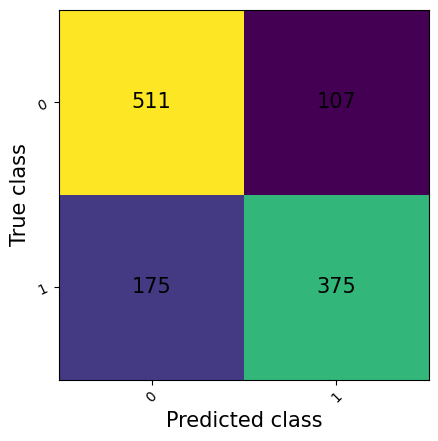

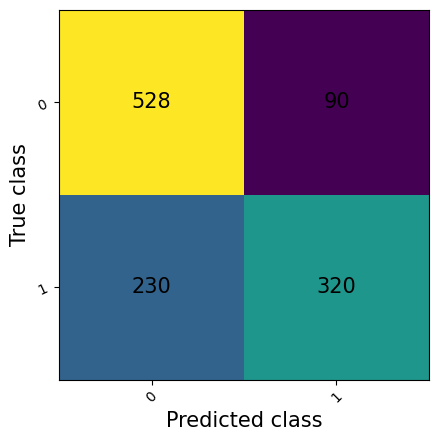

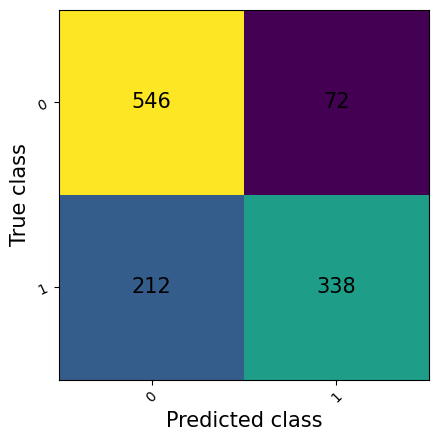

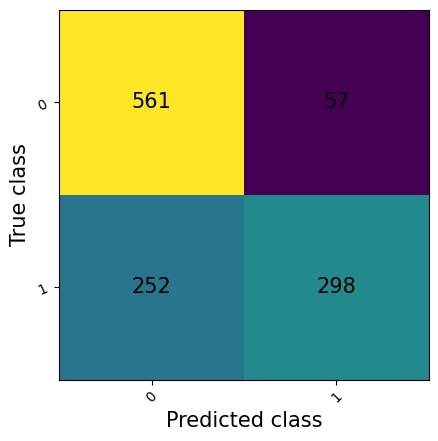

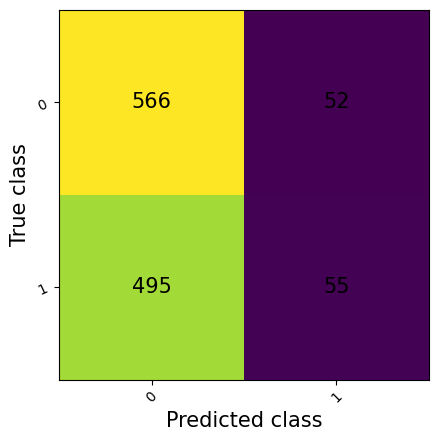

In [44]:
study.optimize(objective, n_trials=120,callbacks=[neptune_callback])

trial = study.best_trial

print('Best Value: {}'.format(trial.value))

print("Best hyperparameters: {}".format(trial.params))

In [ ]:
save_optuna_states()
upload_optuna_states(run=run_study_level,directory="optuna")

In [45]:
run_study_level.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/krishanchavinda.official/Fine-Tuning-DCL-Framework/e/FIN-3215/metadata
